#Install packages and load libraries

Install non-native packages



In [ ]:
%%capture
!pip install scikit-learn==0.22.2.post1
!pip install ipynb

Import common packages

In [ ]:
import cProfile
import datetime, glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle, pstats, sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, average_precision_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, train_test_split

Enable Google Colab, mount drives, and load proprietary modules...

In [ ]:
%%capture
from google.colab import drive, files
drive.mount('/content/drive', force_remount=False)
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/code/code_toPublish')   
import ppiPrediction_v2
import dataProcessing
import modelTraining
import modelEvaluating                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [ ]:
def plotPanels(prjName, panels, outputDir):
  filename = '{0}_Pr-R_Performance'.format(prjName)
  plt.clf()
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24.25, 6))

  for results in panels[0]:
    precRecall_pairs = \
      [dataProcessing.loadResults_precRecall(results[0], results[1])]

    for precRecall_pair in precRecall_pairs:
      precRecall_auc = auc(precRecall_pair[0], precRecall_pair[1])
      ax1.plot(precRecall_pair[0], precRecall_pair[1],
              label=precRecall_pair[2] + ', AUC: {0: .3f}'.format(precRecall_auc))
      ax1.legend(bbox_to_anchor=(0, 0), loc='lower left', ncol=1)
      ax1.set_xlabel('Recall')
      ax1.set_ylabel('Precision')

  for results in panels[1]:
    precRecall_pairs = \
      [dataProcessing.loadResults_precRecall(results[0], results[1])]

    for precRecall_pair in precRecall_pairs:
      precRecall_auc = auc(precRecall_pair[0], precRecall_pair[1])
      ax2.plot(precRecall_pair[0], precRecall_pair[1],
              label=precRecall_pair[2] + ', AUC: {0: .3f}'.format(precRecall_auc))
      ax2.legend(bbox_to_anchor=(0, 0), loc='lower left', ncol=1)
      ax2.set_xlabel('Recall')
      ax2.set_ylabel('Precision')      

  for results in panels[2]:
    precRecall_pairs = \
      [dataProcessing.loadResults_precRecall(results[0], results[1])]

    for precRecall_pair in precRecall_pairs:
      precRecall_auc = auc(precRecall_pair[0], precRecall_pair[1])
      ax3.plot(precRecall_pair[0], precRecall_pair[1],
              label=precRecall_pair[2] + ', AUC: {0: .3f}'.format(precRecall_auc))
      ax3.legend(bbox_to_anchor=(0, 0), loc='lower left', ncol=1)    
      ax3.set_xlabel('Recall')
      ax3.set_ylabel('Precision')              

  filename_wPath = \
    outputDir + filename + '.svg'
  plt.savefig(filename_wPath, bbox_inches='tight', dpi=600)

#Define file paths and key variables

In [ ]:
global dateSignature
dateSignature = datetime.datetime.now().strftime("%Y-%m-%d")

#directories
workDir = '/content/drive/MyDrive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/'
LMprotein_complexesDir = workDir + 'proteinComplexes/Lugo-Martinez/'
GWprotein_complexesDir = workDir + 'proteinComplexes/Drew_LM_Wilkins/'
humap2Dir = workDir + 'proteinComplexes/huMAP_2.0/'
fig1Results_path = workDir + 'ELCFS Manuscript Figures/Fig1/'
fig2Results_path = workDir + 'ELCFS Manuscript Figures/Fig2/'

In [ ]:
humap2PPI_performance = \
  pd.read_csv(humap2Dir + 'humap2ppis_modelPerformance_duplicatesUnchecked.tsv', sep='\t', low_memory=False)

In [ ]:
humap2PPI_performance.idi = humap2PPI_performance.idi.astype('str')
humap2PPI_performance.idii = humap2PPI_performance.idii.astype('str')
humap2PPI_performance.loc[:, 'pairsFrozen'] = humap2PPI_performance.loc[:, ['idi', 'idii']].apply(frozenset, axis=1)

In [ ]:
corumHumap2_pairs = \
    {filename.split('/')[-1].split('humap2_')[1].split('.')[0].split('_geneid_20200818')[0]: 
     pd.read_csv(filename, sep='\t', header=0, names=['idi', 'idii']) 
     for filename in glob.glob(workDir + 'proteinComplexes/huMAP_2.0/humap2_*_ppis_geneid_*.txt')}

for key, value in corumHumap2_pairs.items():
    value.insert(2, 'pairsFrozen', 
                 value.loc[:, ['idi', 'idii']].apply(frozenset, axis=1))
    label = 0 if 'neg' in key else 1
    value.insert(3, 'label', label)
    corumHumap2_pairs[key] = value     

In [ ]:
corumHumap2_pairsTesting = \
  pd.concat(
      [], axis=0, ignore_index=True
  )

In [ ]:
corumHumap2_pairs['train_ppis'].head()

,idi,idii,pairsFrozen,label
0,51428,6627,"(6627, 51428)",1
1,3958,6632,"(6632, 3958)",1
2,5530,8648,"(8648, 5530)",1
3,4720,51079,"(4720, 51079)",1
4,5437,5440,"(5440, 5437)",1


#Fig 1

In [ ]:
panelA = [
    [fig1Results_path + 'drew2017_5CV.txt', 'Drew et al. 2017 '], 
    [fig1Results_path + 'lugo-martinez2019_5CV.txt', 'Lugo-Martinez et al. 2019'],
    [fig1Results_path + 'partitionModel_drew_5CV.csv', 'KD'],
    [fig1Results_path + 'partitionModel_drew+LM_5CV.csv', 'KD+LM'],
    [fig1Results_path + 'partitionModel_drew+LM+New_5CV.csv', 'KD+LM+New']
]

'''
panelA = [
    [fig1Results_path + 'drew2017_5CV.txt', 'Drew et al. 2017 '], 
    [fig1Results_path + 'lugo-martinez2019_5CV.txt', 'Lugo-Martinez et al. 2019'],
    [fig1Results_path + 'drew2021_5CV.csv', 'Drew et al. 2021'],
    [fig1Results_path + 'partitionModel_drew_5CV.csv', 'KD'],
    [fig1Results_path + 'partitionModel_drew+LM_5CV.csv', 'KD+LM'],
    [fig1Results_path + 'partitionModel_drew+LM+New_5CV.csv', 'KD+LM+New']
]
'''

panelB = [
    [fig1Results_path + 'prior_scbc_corr_change/partitionModel_drew+LM+SCBC_5CV.csv', 'KD+LM+SCBC'],
    [fig1Results_path + 'prior_scbc_corr_change/partitionModel_drew+LM+New+SCBC_5CV.csv', 'KD+LM+New+SCBC']    
]

panelC = [
    [fig1Results_path + 'post_scbc_corr_change/partitionModel_drew+LM+SCBC_5CV.csv', 'KD+LM+SCBC'],
    [fig1Results_path + 'post_scbc_corr_change/partitionModel_drew+LM+New+SCBC_5CV.csv', 'KD+LM+New+SCBC']    
]

fig1 = [panelA, panelB, panelC]

<Figure size 432x288 with 0 Axes>

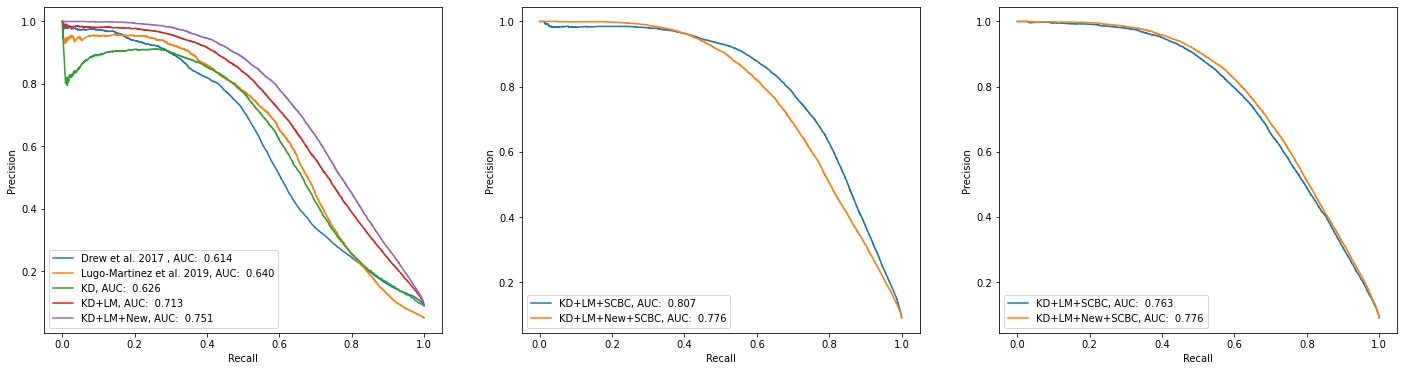

In [ ]:
plotPanels('Fig1', fig1, './')

#Fig 2

In [ ]:
panelA = [
    [fig2Results_path + 'lugo-martinez2019_HPA-NCI60-expandedPairs_5CV.txt', 'Lugo-Martinez et al. 2019'],
    [fig2Results_path + 'partitionModel_drew+LM_HPA-NCI60-expandedPairs_5CV.txt', 'KD+LM'],
    [fig2Results_path + 'partitionModel_KD_LM_FGK.txt', 'KD+LM+New']
]

panelB = [
    [fig2Results_path + 'prior_scbc_corr_change/partitionModel_drew+LM+SCBC_HPA-NCI60-expandedPairs_5CV.csv', 'KD+LM+SCBC'],
    [fig2Results_path + 'prior_scbc_corr_change/partitionModel_drew+LM+SCBC+Fantom+GTEx+Modelzoo_HPA-NCI60-expandedPairs_5CV.csv', 'KD+LM+New+SCBC']    
]

panelC = [
    [fig2Results_path + 'post_scbc_corr_change/partitionModel_KD+LM+SCBC_noSCBCnull.csv', 'KD+LM+SCBC'],
    [fig2Results_path + 'post_scbc_corr_change/partitionModel_KD+LM+FGK+SCBC_cellSpecific_nci60Feats_noSCBCnulls.csv', 'KD+LM+New+SCBC']    
]

fig2 = [panelA, panelB, panelC]

<Figure size 432x288 with 0 Axes>

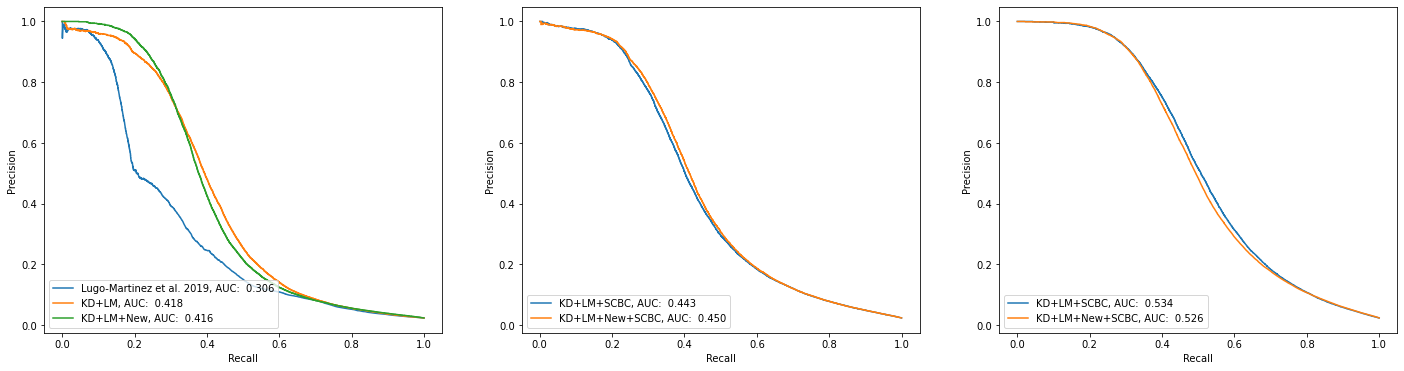

In [ ]:
plotPanels('Fig2', fig2, './')

FileNotFoundError: ignored

<Figure size 432x288 with 0 Axes>

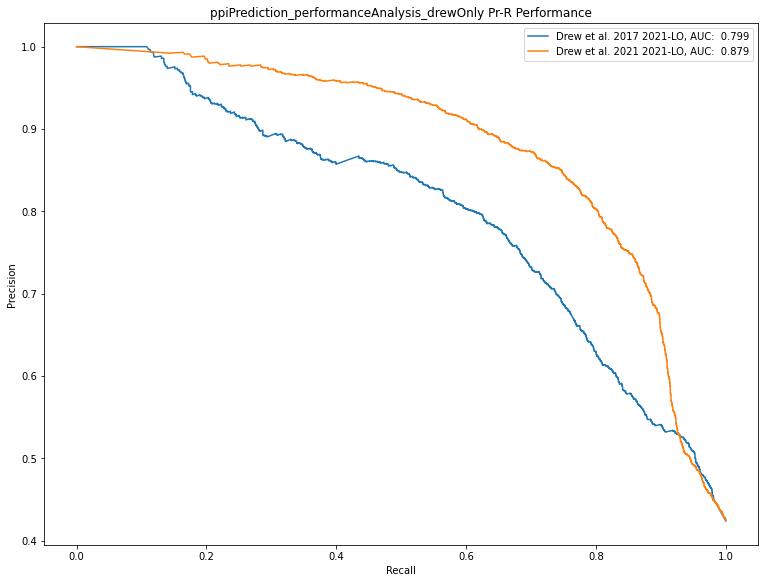

In [ ]:
drewPerformances_forComparision = [
    ['./humap1PPI_performance_testPairs_2017_combined-weighted_results.csv', 'Drew et al. 2017 2021-LO'], 
    ['./humap2PPI_performance_testPairs_2021_combined-weighted_results.csv', 'Drew et al. 2021 2021-LO']
    ]  

precRecall_pairs = []
for cmpPerformance in drewPerformances_forComparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, 'ppiPrediction_performanceAnalysis_drewOnly', precRecall_pairs)

#Unit-Accuracy and Combined-Weight Performance Compared to Drew et al. 2017 and Lugo-Martinez et al. 2019 with added features, colocalization and coexpression, on original protein pair set

In [ ]:
performances4Comparision = [
                            [LMprotein_complexesDir + 'drew_BCB_features_test_all_model_predictions_rf_400_prc.txt', 'Drew et al. 2017 '], 
                            [LMprotein_complexesDir + 'drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model_predictions_rf_400_prc2.txt', 'Lugo-Martinez et al. 2019'], 
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_drewOnly/combined-weighted_results.csv', 'Weighted'],                                   
                            [workDir + 'modelPerformance/modelsPerformance_RF_origJLM_completePartitions/priorRun/drewPlus_combinedWeighted_results.csv', 'Weighted w/ Added LM Features']
                            ]

Loading data...
The shape of the data is (108810, 258)
The shape of labels is (108810, 1)
Completed loading data
________________________________________________
Loading data...
The shape of the data is (118644, 258)
The shape of labels is (118644, 1)
Completed loading data
________________________________________________
Extracting unique feature combinations from training data
The number of unique feature combinations are 17 and the shape of unique counts is (17,)
Completed extracting unique feature combinations from training data
________________________________________________
Extracting unique feature combinations from testing data
The number of unique feature combinations are 17 and the shape of unique counts is (17,)
Completed extracting unique feature combinations from testing data
________________________________________________
Training models per partition of the training data
____________________________________________________________
Progress: 0/17 
Loading model from dis

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.058823529411764705


[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0

progress: 0.11764705882352941


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.5s
[Para

progress: 0.17647058823529413


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.23529411764705882


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0

progress: 0.29411764705882354


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Do

progress: 0.35294117647058826


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4117647058823529


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.47058823529411764


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.4s
[Para

progress: 0.5294117647058824


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5882352941176471


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6470588235294118


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7058823529411765


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7647058823529411


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8235294117647058


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8823529411764706


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.9411764705882353


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

Streaming output truncated to the last 5000 lines.
progress: 0.9579498331141904
progress: 0.9579582616904353
progress: 0.9579666902666801
progress: 0.9579751188429251
progress: 0.9579835474191699
progress: 0.9579919759954149
progress: 0.9580004045716598
progress: 0.9580088331479046
progress: 0.9580172617241496
progress: 0.9580256903003944
progress: 0.9580341188766394
progress: 0.9580425474528843
progress: 0.9580509760291291
progress: 0.9580594046053741
progress: 0.9580678331816189
progress: 0.9580762617578639
progress: 0.9580846903341088
progress: 0.9580931189103536
progress: 0.9581015474865986
progress: 0.9581099760628434
progress: 0.9581184046390884
progress: 0.9581268332153333
progress: 0.9581352617915782
progress: 0.9581436903678231
progress: 0.9581521189440679
progress: 0.9581605475203129
progress: 0.9581689760965578
progress: 0.9581774046728027
progress: 0.9581858332490476
progress: 0.9581942618252924
progress: 0.9582026904015374
progress: 0.9582111189777823
progress: 0.958219547

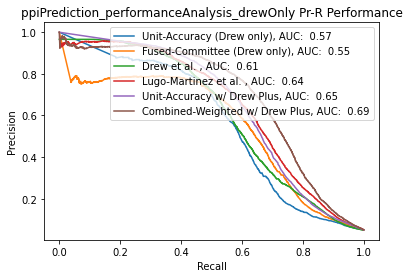

In [ ]:
#get models and evaluate
precAcc_drewFeats, recAcc_drewFeats, precWeighted_drewFeats, recWeighted_drewFeats = ppiPrediction_v2.run(workDir, 
                                                                                                         LMprotein_complexesDir + 'drew_Drewetal_features_training_all_model.tsv', 
                                                                                                         LMprotein_complexesDir + 'drew_training_labels_all_model.tsv',
                                                                                                         LMprotein_complexesDir + 'drew_Drewetal_features_test_all_model.tsv',
                                                                                                         LMprotein_complexesDir + 'drew_test_labels_all_model.tsv'
                                                                                                         expName='ppiPrediction_performanceAnalysis_drewOnly')

precAcc, recAcc, precWeighted, recWeighted = ppiPrediction_v2.run(workDir, 
                                                                  LMprotein_complexesDir + 'drew_MM+TSCS+Exp+Abun+Loc_features_training_all_model.tsv, 
                                                                  LMprotein_complexesDir + 'drew_training_labels_all_model.tsv', 
                                                                  LMprotein_complexesDir + 'drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model.tsv', 
                                                                  LMprotein_complexesDir + 'drew_test_labels_all_model.tsv', 
                                                                  expName='ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures') 

#plot performance
precRecall_pairs = []
for cmpPerformance in drewPerformances_forComparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, 'ppiPrediction_performanceAnalysis_drewOnly', precRecall_pairs)

#Unit-Accuracy and Combined-Weight Cell-Type Specific (A431, MCF7, U251) Performance Compared to Drew et al. 2017 and Lugo-Martinez et al. 2019 with added features, colocalization and coexpression, on original protein pair set

In [ ]:
performances4Comparision = [
                            [LMprotein_complexesDir + 'drew_BCB_features_test_all_model_predictions_rf_400_prc.txt', 'Drew et al. 2017 '], 
                            [LMprotein_complexesDir + 'drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model_predictions_rf_400_prc2.txt', 'Lugo-Martinez et al. 2019'], 
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_drewOnly/unit-accuracy_results.csv', 'Unit-Accuracy'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_drewOnly/combined-weighted_results.csv', 'Combined-Weighted'],                                   
                            [workDir + 'modelPerformance/modelsPerformance_RF_origJLM_completePartitions/priorRun/drewPlus_unitAccuracy_results.csv', 'Unit-Accuracy w/ Added LM Features'], 
                            [workDir + 'modelPerformance/modelsPerformance_RF_origJLM_completePartitions/priorRun/drewPlus_combinedWeighted_results.csv', 'Combined-Weighted w/ Added LM Features'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_drewPlus--A431/unit-accuracy_results.csv', 'Unit-Accuracy w/ LM-A431 Specific'], 
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_drewPlus--A431/combined-weighted_results.cs', 'Combined-Weighted w/ LM-A431 Specific'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_drewPlus--MCF7/unit-accuracy_results.csv', 'Unit-Accuracy w/ LM-MCF7 Specific'], 
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_drewPlus--MCF7/combined-weighted_results.cs', 'Combined-Weighted w/ LM-MCF7 Specific'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_drewPlus--U251/unit-accuracy_results.csv', 'Unit-Accuracy w/ LM-U251 Specific'], 
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_drewPlus--U251/combined-weighted_results.cs', 'Combined-Weighted w/ LM-U251 Specific']                                                                                    
                            ]

In [ ]:
#get models and evaluate
precAcc, recAcc, precWeighted, recWeighted = ppiPrediction_v2.run(workDir, 
                                                                  GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_training_all_model--corr_A431.tsv', 
                                                                  LMprotein_complexesDir + 'drew_training_labels_all_model.tsv', 
                                                                  GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model--corr_A431.tsv', 
                                                                  LMprotein_complexesDir + 'drew_test_labels_all_model.tsv', 
                                                                  expName='ppiPrediction_performanceAnalysis_drewPlus--A431') 

precAcc, recAcc, precWeighted, recWeighted = ppiPrediction_v2.run(workDir, 
                                                                  GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_training_all_model--corr_MCF7.tsv', 
                                                                  LMprotein_complexesDir + 'drew_training_labels_all_model.tsv', 
                                                                  GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model--corr_MCF7.tsv', 
                                                                  LMprotein_complexesDir + 'drew_test_labels_all_model.tsv', 
                                                                  expName='ppiPrediction_performanceAnalysis_drewPlus--MCF7') 

precAcc, recAcc, precWeighted, recWeighted = ppiPrediction_v2.run(workDir, 
                                                                  GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_training_all_model--corr_U251.tsv', 
                                                                  LMprotein_complexesDir + 'drew_training_labels_all_model.tsv', 
                                                                  GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model--corr_U251.tsv', 
                                                                  LMprotein_complexesDir + 'drew_test_labels_all_model.tsv', 
                                                                  expName='ppiPrediction_performanceAnalysis_drewPlus--U251') 

#plot performance
precRecall_pairs = []
for cmpPerformance in drewPerformances_forComparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, 'ppiPrediction_performanceAnalysis_cellLine-Specific', precRecall_pairs)

#Unit-Accuracy and Combined-Weight 5-fold Cross Validation Performance Compared to Drew et al. 2017 and Lugo-Martinez et al. 2019 with added features, colocalization and coexpression, on original protein pair set

In [ ]:
performances4Comparision = [
                            [LMprotein_complexesDir + 'drew_BCB_features_all_model_cv_predictions_rf_400_prc.txt', 'Drew et al. 2017 5CV'],
                            [LMprotein_complexesDir + 'lugo-martinez_etal_BCB_features_all_model_cv_predictions_rf_400_prc.txt', 'Lugo-Martinez et al. 2019 5CV'],
                            [workDir + 'modelPerformance/modelsPerformance_origPairs_reCheck_5CV/unit-accuracy_results.csv', 'Best Partition 5CV'],
                            [workDir + 'modelPerformance/modelsPerformance_origPairs_reCheck_5CV/combined-weighted_results.csv', 'Weighted 5CV'],
                            [workDir + 'modelPerformance/modelsPerformance_origPairs_drewPlus-5CV/unit-accuracy_results.csv', 'Best Partition w/ Added LM Features 5CV'],
                            [workDir + 'modelPerformance/modelsPerformance_origPairs_drewPlus-5CV/combined-weighted_results.csv', 'Weighted w/ Added LM Features 5CV']                            
                            ]

w/o LM added features

In [ ]:
dataProcessing.createCV_trainTest_splits(workDir + 'dataPartitions/', 
                                         LMprotein_complexesDir + 'drew_Drewetal_features_training_all_model.tsv', LMprotein_complexesDir + 'drew_training_labels_all_model.tsv', 
                                         LMprotein_complexesDir + 'drew_Drewetal_features_test_all_model.tsv', LMprotein_complexesDir + 'drew_test_labels_all_model.tsv',
                                         5, 'origPairs')

In [ ]:
for fold in np.arange(5):
    dir = workDir + '/dataPartitions/origPairs_5CV/origPairs_5CV_{0}/'.format(fold)
    ppiPrediction_v2.run(workDir,
                        dir + 'trainingData.tsv', dir + 'trainingLabels.tsv',
                        dir + 'testData.tsv', dir + 'testLabels.tsv',
                        expName='modelsPerformance_origPairs_reCheck_5CV_{0}'.format(fold))

In [ ]:
modelEvaluating.plot_kCV_prr(workDir, workDir + 'modelPerformance/modelsPerformance_origPairs_reCheck_5CV_*/', 5, 'modelsPerformance_origPairs_reCheck_5CV')

w/ LM added features

In [ ]:
dataProcessing.createCV_trainTest_splits(workDir + 'dataPartitions/', 
                                         LMprotein_complexesDir + 'drew_MM+TSCS+Exp+Abun+Loc_features_training_all_model.tsv', LMprotein_complexesDir + 'drew_training_labels_all_model.tsv', 
                                         LMprotein_complexesDir + 'drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model.tsv', LMprotein_complexesDir + 'drew_test_labels_all_model.tsv',
                                         5, 'origPairs_drewPlus')

In [ ]:
#get models and evaluate
for fold in np.arange(5):
    dir = workDir + '/dataPartitions/origPairs_drewPlus/origPairs_drewPlus_{0}/'.format(fold)
    ppiPrediction_v2.run(workDir,
                        dir + 'trainingData.tsv', dir + 'trainingLabels.tsv',
                        dir + 'testData.tsv', dir + 'testLabels.tsv',
                        expName='modelsPerformance_origPairs_drewPlus_reCheck_5CV_{0}'.format(fold))

In [ ]:
modelEvaluating.plot_kCV_prr(workDir, workDir + 'modelPerformance/modelsPerformance_origPairs_drewPlus_reCheck_5CV_*/', 5, 'modelsPerformance_origPairs_drewPlus_reCheck_5CV')

FileNotFoundError: ignored

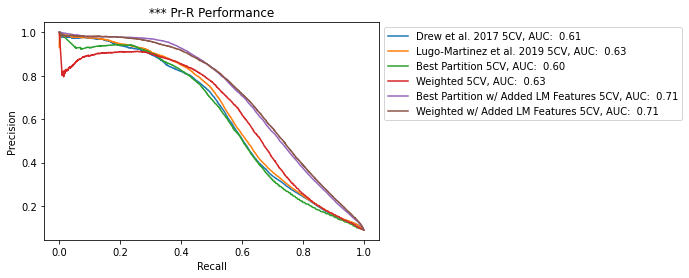

In [ ]:
#plot performance
precRecall_pairs = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, '***', precRecall_pairs)

#Unit-Accuracy and Combined-Weight Performance Compared to Drew et al. 2017 and Lugo-Martinez et al. 2019 with added features, colocalization and coexpression, on original protein pair set (5 SCBC-sourced cell-line average correlation features added)

In [ ]:
performances4Comparision = [
                            [LMprotein_complexesDir + 'drew_BCB_features_test_all_model_predictions_rf_400_prc.txt', 'Drew et al. 2017 '], 
                            [LMprotein_complexesDir + 'drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model_predictions_rf_400_prc2.txt', 'Lugo-Martinez et al. 2019'], 
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_drewOnly/combined-weighted_results.csv', 'Weighted'],                                   
                            [workDir + 'modelPerformance/modelsPerformance_RF_origJLM_completePartitions/priorRun/drewPlus_combinedWeighted_results.csv', 'Weighted w/ Added LM Features'],
                            [workDir + 'modelPerformance/modelsPerformance_origJLM+SCBCv3/combined-weighted_results.csv', 'Weighted (Added LM, SCBC)']
                            ]

In [ ]:
ppiPrediction_v2.run(workDir, 
                     workDir + 'proteinComplexes/Drew_LM_Wilkins/trainingData_scbcMerged_5LinesCorr.tsv', 
                     LMprotein_complexesDir + 'drew_training_labels_all_model.tsv',
                     workDir + 'proteinComplexes/Drew_LM_Wilkins/testData_scbcMerged_5LinesCorr.tsv',
                     LMprotein_complexesDir + 'drew_test_labels_all_model.tsv',
                     expName='origJLM+SCBCv3')

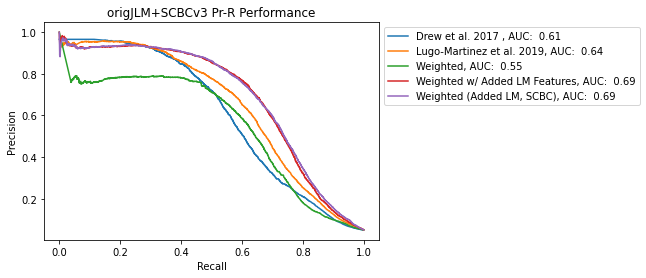

In [ ]:
precRecall_pairs = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, 'origJLM+SCBCv3', precRecall_pairs)

#Unit-Accuracy and Combined-Weight 5-fold Cross Validation Performance Compared to Drew et al. 2017 and Lugo-Martinez et al. 2019 with added features, colocalization and coexpression, on original protein pair set (5 SCBC-sourced cell-line average correlation features added)

In [ ]:
#keeping all
performances4Comparision = [
                            [LMprotein_complexesDir + 'drew_BCB_features_all_model_cv_predictions_rf_400_prc.txt', 'Drew et al. 2017 5CV'],
                            [LMprotein_complexesDir + 'lugo-martinez_etal_BCB_features_all_model_cv_predictions_rf_400_prc.txt', 'Lugo-Martinez et al. 2019 5CV'],
                            [workDir + 'modelPerformance/modelsPerformance_origPairs_reCheck_5CV/combined-weighted_results.csv', 'KD'],
                            [workDir + 'modelPerformance/modelsPerformance_origPairs_drewPlus-5CV/combined-weighted_results.csv', 'KD+LM'],                            
                            [workDir + 'modelPerformance/modelsPerformance_origPairs_drewPlus+SCBC_recheck-5CV/combined-weighted_results.csv', 'KD+LM+SCBC Corr'],
                            [workDir + 'modelPerformance/modelsPerformance_drewPairs_KD+LM+FGK_5CV/combined-weighted_results.csv', 'KD+LM+New'],
                            [workDir + 'modelPerformance/modelsPerformance_drewPairs_KD+LM+SCBCfracCorr_5CV/combined-weighted_results.csv', 'KD+LM+SCBC Frac Corr'],                            
                            [workDir + 'modelPerformance/modelsPerformance_drewPairs_KD+LM+FGK+SCBCfracCorr_5CV/combined-weighted_results.csv', 'KD+LM+New+SCBC Frac Corr'],                            
                            ]

In [ ]:
#keeping just Murphy's, re notes (notes 20220526 (murphy manuscript))
performances4Comparision = [
                            [LMprotein_complexesDir + 'drew_BCB_features_all_model_cv_predictions_rf_400_prc.txt', 'Drew et al. 2017 5CV'],
                            [LMprotein_complexesDir + 'lugo-martinez_etal_BCB_features_all_model_cv_predictions_rf_400_prc.txt', 'Lugo-Martinez et al. 2019 5CV'],
                            [workDir + 'modelPerformance/modelsPerformance_origPairs_reCheck_5CV/combined-weighted_results.csv', 'KD'],
                            [workDir + 'modelPerformance/modelsPerformance_origPairs_drewPlus-5CV/combined-weighted_results.csv', 'KD+LM'],                            
                            [workDir + 'modelPerformance/modelsPerformance_drewPairs_KD+LM+FGK_5CV/combined-weighted_results.csv', 'KD+LM+New'],
                            [workDir + 'modelPerformance/modelsPerformance_drewPairs_KD+LM+SCBCfracCorr_5CV/combined-weighted_results.csv', 'KD+LM+SCBC Frac Corr'],                            
                            [workDir + 'modelPerformance/modelsPerformance_drewPairs_KD+LM+FGK+SCBCfracCorr_5CV/combined-weighted_results.csv', 'KD+LM+New+SCBC Frac Corr'],                            
                            ]

In [ ]:
dataProcessing.createCV_trainTest_splits(workDir + 'dataPartitions/', 
                                         LMprotein_complexesDir + ***HAVE TO MERGE SCBC WITH DREW PLUS***, LMprotein_complexesDir + ***HAVE TO MERGE SCBC WITH DREW PLUS***, 
                                         LMprotein_complexesDir + ***HAVE TO MERGE SCBC WITH DREW PLUS***, LMprotein_complexesDir + ***HAVE TO MERGE SCBC WITH DREW PLUS***,
                                         5, 'origLM+SCBC')                                                                  

In [ ]:
#get models and evaluate
for fold in np.arange(5):
    dir = workDir + '/dataPartitions/origLM+SCBC_5CV/origLM+SCBC_5CV_{0}/'.format(fold)
    ppiPrediction_v2.run(workDir,
                        dir + 'trainingData.tsv', dir + 'trainingLabels.tsv',
                        dir + 'testData.tsv', dir + 'testLabels.tsv',      
                        expName='modelsPerformance_origPairs_drewPlus+SCBC_5CV_{0}'.format(fold))

In [ ]:
modelEvaluating.plot_kCV_prr(workDir, workDir + 'modelPerformance/modelsPerformance_origPairs_drewPlus+SCBC_5CV_*/', 5, 'origPairs_drewPlus+SCBC')

In [ ]:
#plot performance
precRecall_pairs = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis('/content/', 'New Fig 1 (keep all)', precRecall_pairs)

#Unit-Accuracy and Combined-Weight Performance Compared to Drew et al. 2017 and Lugo-Martinez et al. 2019 on original protein pair set expanded to include pairs for which colocalization, coexpression are available

In [ ]:
performances4Comparision = [
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/drewJLM_expandedPPI_results.csv', 'Lugo-Martinez et al.'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/unit-accuracy_results.csv', 'Best Partition w/ Added LM Features'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/combined-weighted_results.csv', 'Weighted w/ Added LM Features']
                            ]

In [ ]:
#get models and evaluate
precAcc, recAcc, precWeighted, recWeighted = ppiPrediction_v2.run(workDir, 
                                                                 LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model.tsv', 
                                                                 LMprotein_complexesDir + 'integrated_training_labels_either_model.tsv',
                                                                 LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_test_either_model.tsv',
                                                                 LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv',
                                                                 expName='ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures')                                                                                                  

Loading data...
The shape of the data is (491525, 268)
The shape of labels is (491525, 3)
Completed loading data
________________________________________________
Loading data...
The shape of the data is (546646, 268)
The shape of labels is (546646, 3)
Completed loading data
________________________________________________
Training models per partition of the training data
____________________________________________________________
Progress: 0/263 
Loading model from disk...
Completed loading model from disk...
______________________________
Progress: 1/263 
Loading model from disk...
Completed loading model from disk...
______________________________
Progress: 2/263 
Loading model from disk...
Completed loading model from disk...
______________________________
Progress: 3/263 
Loading model from disk...
Completed loading model from disk...
______________________________
Progress: 4/263 
Loading model from disk...
Completed loading model from disk...
______________________________
Prog

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   10.4s
[Para

progress: 0.0038022813688212928


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    3.9s
[Para

progress: 0.0076045627376425855


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    4.0s
[Para

progress: 0.011406844106463879


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    2.2s
[Para

progress: 0.015209125475285171


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.019011406844106463


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.022813688212927757


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.026615969581749048


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.030418250950570342


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.034220532319391636


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.03802281368821293


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.04182509505703422


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.045627376425855515


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    4.4s
[Para

progress: 0.049429657794676805


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    2.2s
[Para

progress: 0.053231939163498096


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.7s
[Para

progress: 0.057034220532319393


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.2s
[Para

progress: 0.060836501901140684


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.06463878326996197


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.06844106463878327


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.07224334600760456


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.07604562737642585


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.07984790874524715


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.08365019011406843


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.08745247148288973


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0

progress: 0.09125475285171103


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    4.7s
[Para

progress: 0.09505703422053231


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.9s
[Para

progress: 0.09885931558935361


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    2.4s
[Para

progress: 0.10266159695817491


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.3s
[Para

progress: 0.10646387832699619


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.11026615969581749


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.11406844106463879


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.11787072243346007


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.12167300380228137


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.12547528517110265


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.12927756653992395


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.13307984790874525


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.13688212927756654


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    2.6s
[Para

progress: 0.14068441064638784


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.3s
[Para

progress: 0.1444866920152091


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.2s
[Para

progress: 0.1482889733840304


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.9s
[Para

progress: 0.1520912547528517


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.155893536121673


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.1596958174904943


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.1634980988593156


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.16730038022813687


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0

progress: 0.17110266159695817


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0

progress: 0.17490494296577946


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.17870722433460076


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.18250950570342206


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.4s
[Para

progress: 0.18631178707224336


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.19011406844106463


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.19391634980988592


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.19771863117870722


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.20152091254752852


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.20532319391634982


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.20912547528517111


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.21292775665399238


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0

progress: 0.21673003802281368


[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_job

progress: 0.22053231939163498


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.22433460076045628


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.22813688212927757


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.23193916349809887


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.23574144486692014


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.23954372623574144


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.24334600760456274


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.24714828897338403


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.2509505703422053


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.25475285171102663


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.2585551330798479


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.2623574144486692


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.2661596958174905


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.26996197718631176


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.2737642585551331


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.27756653992395436


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.2813688212927757


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.28517110266159695


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.2889733840304182


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.29277566539923955


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.2965779467680608


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.30038022813688214


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.3041825095057034


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.30798479087452474


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.311787072243346


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.3155893536121673


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.3193916349809886


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.3231939163498099


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.3269961977186312


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.33079847908745247


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.33460076045627374


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.33840304182509506


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.34220532319391633


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.34600760456273766


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0

progress: 0.34980988593155893


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.35361216730038025


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.3574144486692015


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.3612167300380228


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.3650190114068441


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.3688212927756654


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.3726235741444867


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.376425855513308


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0

progress: 0.38022813688212925


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.3840304182509506


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.38783269961977185


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.3916349809885932


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.39543726235741444


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.39923954372623577


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.40304182509505704


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.4068441064638783


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0

progress: 0.41064638783269963


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.4144486692015209


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.41825095057034223


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0

progress: 0.4220532319391635


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.42585551330798477


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.4296577946768061


[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worke

progress: 0.43346007604562736


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4372623574144487


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.44106463878326996


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.4448669201520912


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0

progress: 0.44866920152091255


[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_job

progress: 0.4524714828897338


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.45627376425855515


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4600760456273764


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.46387832699619774


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.467680608365019


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0

progress: 0.4714828897338403


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0

progress: 0.4752851711026616


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0

progress: 0.4790874524714829


[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0

progress: 0.4828897338403042


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4866920152091255


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.49049429657794674


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.49429657794676807


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.49809885931558934


[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0

progress: 0.5019011406844106


[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0

progress: 0.5057034220532319


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.5095057034220533


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.5133079847908745


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.2s
[Para

progress: 0.5171102661596958


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.7s
[Para

progress: 0.5209125475285171


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.7s
[Para

progress: 0.5247148288973384


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.5s
[Para

progress: 0.5285171102661597


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.532319391634981


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5361216730038023


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5399239543726235


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5437262357414449


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5475285171102662


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5513307984790875


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5551330798479087


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.55893536121673


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.7s
[Para

progress: 0.5627376425855514


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.5s
[Para

progress: 0.5665399239543726


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.4s
[Para

progress: 0.5703422053231939


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.4s
[Para

progress: 0.5741444866920152


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5779467680608364


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5817490494296578


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5855513307984791


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5893536121673004


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5931558935361216


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.596958174904943


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.6007604562737643


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.7s
[Para

progress: 0.6045627376425855


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.5s
[Para

progress: 0.6083650190114068


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.5s
[Para

progress: 0.6121673003802282


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.6159695817490495


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6197718631178707


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.623574144486692


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6273764258555133


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6311787072243346


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.6349809885931559


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.6387832699619772


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.6425855513307985


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.6463878326996197


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.4s
[Para

progress: 0.6501901140684411


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.6539923954372624


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.6577946768060836


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.6615969581749049


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6653992395437263


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6692015209125475


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6730038022813688


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6768060836501901


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6806083650190115


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6844106463878327


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.688212927756654


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6920152091254753


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6958174904942965


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6996197718631179


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7034220532319392


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7072243346007605


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7110266159695817


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.714828897338403


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7186311787072244


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.7224334600760456


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.7262357414448669


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.7300380228136882


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7338403041825095


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7376425855513308


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7414448669201521


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7452471482889734


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7490494296577946


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.752851711026616


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7566539923954373


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7604562737642585


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7642585551330798


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7680608365019012


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.7718631178707225


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.7756653992395437


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.779467680608365


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7832699619771863


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7870722433460076


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7908745247148289


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7946768060836502


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7984790874524715


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8022813688212928


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8060836501901141


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8098859315589354


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.8136882129277566


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8174904942965779


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8212927756653993


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8250950570342205


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8288973384030418


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8326996197718631


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8365019011406845


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8403041825095057


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.844106463878327


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8479087452471483


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8517110266159695


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8555133079847909


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.8593155893536122


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8631178707224335


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8669201520912547


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.870722433460076


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8745247148288974


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8783269961977186


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8821292775665399


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8859315589353612


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.8897338403041825


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8935361216730038


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8973384030418251


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9011406844106464


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9049429657794676


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.908745247148289


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.9125475285171103


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.9163498098859315


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.9201520912547528


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9239543726235742


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.9277566539923955


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.9315589353612167


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.935361216730038


[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.9391634980988594


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.9429657794676806


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.9467680608365019


[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.9505703422053232


[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0

progress: 0.9543726235741445


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0

progress: 0.9581749049429658


[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worke

progress: 0.9619771863117871


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.9657794676806084


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9695817490494296


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.973384030418251


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9771863117870723


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9809885931558935


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.9847908745247148


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9885931558935361


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9923954372623575


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Do

progress: 0.9961977186311787


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Do

Streaming output truncated to the last 5000 lines.
progress: 0.9908734354591454
progress: 0.9908752647965959
progress: 0.9908770941340466
progress: 0.9908789234714971
progress: 0.9908807528089476
progress: 0.9908825821463982
progress: 0.9908844114838488
progress: 0.9908862408212994
progress: 0.9908880701587499
progress: 0.9908898994962004
progress: 0.9908917288336511
progress: 0.9908935581711016
progress: 0.9908953875085521
progress: 0.9908972168460027
progress: 0.9908990461834533
progress: 0.9909008755209039
progress: 0.9909027048583544
progress: 0.9909045341958049
progress: 0.9909063635332556
progress: 0.9909081928707061
progress: 0.9909100222081566
progress: 0.9909118515456072
progress: 0.9909136808830578
progress: 0.9909155102205084
progress: 0.9909173395579589
progress: 0.9909191688954094
progress: 0.9909209982328601
progress: 0.9909228275703106
progress: 0.9909246569077611
progress: 0.9909264862452117
progress: 0.9909283155826623
progress: 0.9909301449201129
progress: 0.990931974

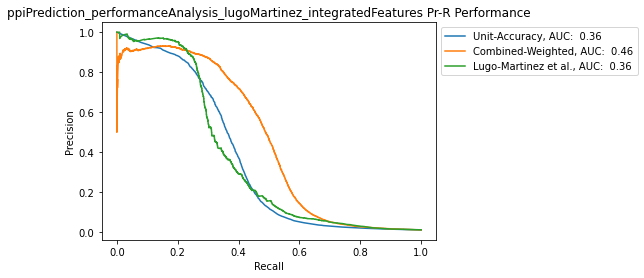

In [ ]:
#plot performance
precRecall_pairs = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, 'ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures', precRecall_pairs)

##archived results (with Drew compensation)

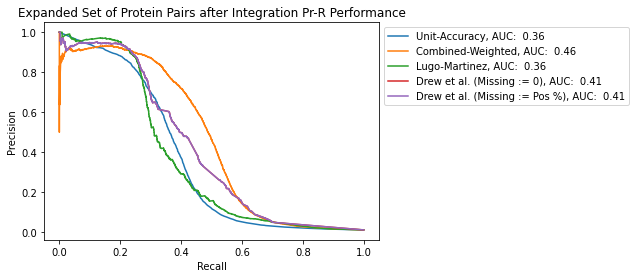

In [ ]:
#get models and evaluate
precAcc, recAcc, precWeighted, recWeighted = modelEvaluating.run(workDir, 
                                                                 LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model.tsv', 
                                                                 LMprotein_complexesDir + 'integrated_training_labels_either_model.tsv',
                                                                 LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_test_either_model.tsv',
                                                                 LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv',
                                                                 expName='ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures')                                                                                                  

#plot performance
precRecall_pairs = [[recAcc, precAcc, 'Unit-Accuracy'], [recWeighted, precWeighted, 'Combined-Weighted']]
for cmpPerformance in drewPerformances_afterIntegrated_forComparison:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, 'ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures', precRecall_pairs)

#Unit-Accuracy and Combined-Weight 5-fold Cross Validation Performance Compared to Drew et al. 2017 and Lugo-Martinez et al. 2019 on original protein pair set expanded to include pairs for which colocalization, coexpression are available

In [ ]:
dataProcessing.createCV_trainTest_splits(workDir + 'dataPartitions/', 
                                         LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model.tsv', 
                                         LMprotein_complexesDir + 'integrated_training_labels_either_model.tsv', 
                                         LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_test_either_model.tsv', 
                                         LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv',
                                         5, 'integratedPairs_reCheck')

In [ ]:
performances4Comparision = [
                            [workDir + 'proteinComplexes/Lugo-Martinez/integrated_MM+TSCS+Exp+Abun+Loc_features_either_model_cv_predictions_rf_400_prc.txt', 'Lugo-Martinez et al. kCV'],
                            [workDir + 'modelPerformance/modelsPerformance_integratedPairs_reCheck_5CV/unit-accuracy_results.csv', 'Best Partition w/ Added LM Features 5CV'],
                            [workDir + 'modelPerformance/modelsPerformance_integratedPairs_reCheck_5CV/combined-weighted_results.csv', 'Weighted w/ Added LM Features 5CV']
                            ]

In [ ]:
#get models and evaluate
for fold in np.arange(5):
    dir = workDir + '/dataPartitions/integratedPairs_reCheck_5CV/integratedPairs_reCheck_5CV_{0}/'.format(fold)
    ppiPrediction_v2.run(workDir,
                        dir + 'trainingData.tsv', dir + 'trainingLabels.tsv',
                        dir + 'testData.tsv', dir + 'testLabels.tsv',
                        expName='integratedPairs_reCheck_5CV_{0}'.format(fold)                                                                                          

In [ ]:
modelEvaluating.plot_kCV_prr(workDir, workDir + 'modelPerformance/modelsPerformance_integratedPairs_reCheck_5CV_*/', 5, 'modelsPerformance_integratedPairs_reCheck_5CV')

In [ ]:
#plot performance
precRecall_pairs = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, 'integratedPairs_reCheck_5CV', precRecall_pairs)

#Unit-Accuracy and Combined-Weight Performance Compared to Drew et al. 2017 and Lugo-Martinez et al. 2019 on original protein pair set expanded to include pairs for which colocalization, coexpression are available (5 SCBC-sourced cell-line average correlation features added)

In [ ]:
performances4Comparision = [
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/archive/drewJLM_expandedPPI_results.csv', 'Lugo-Martinez et al.'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/combined-weighted_results.csv', 'Weighted w/ Added LM Features'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures+SCBC/combined-weighted_results.csv', 'Weighted (Added LM, SCBC)'],
                            [workDir + 'modelPerformance/modelsPerformance_integratedPairs_MM+TSCS+Exp+Abun+Loc+Kaggle+SCBC/combined-weighted_results.csv', 'Weighted w/ LM, SCBC, +FGK']
                            ]

In [ ]:
precAcc, recAcc, precWeighted, recWeighted = ppiPrediction_v2.run(workDir, 
                                                                 GWprotein_complexesDir +  'SCBC-merged_integrated_MM+TSCS+Exp+Abun+Loc_training_ppiData.tsv', 
                                                                 LMprotein_complexesDir + 'integrated_training_labels_either_model.tsv',
                                                                 GWprotein_complexesDir + 'SCBC-merged_integrated_MM+TSCS+Exp+Abun+Loc_test_ppiData.tsv',
                                                                 LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv',
                                                                 expName='ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures+SCBC')  

In [ ]:
precRecall_pairs = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, '', precRecall_pairs)

#Unit-Accuracy and Combined-Weight 5-fold Cross Validation Performance Compared to Drew et al. 2017 and Lugo-Martinez et al. 2019 on original protein pair set expanded to include pairs for which colocalization, coexpression are available (5 SCBC-sourced cell-line average correlation features added)

In [ ]:
dataProcessing.createCV_trainTest_splits(workDir + 'dataPartitions/', 
                                         GWprotein_complexesDir +  'SCBC-merged_integrated_MM+TSCS+Exp+Abun+Loc_training_ppiData.tsv', 
                                         LMprotein_complexesDir + 'integrated_training_labels_either_model.tsv',
                                         GWprotein_complexesDir + 'SCBC-merged_integrated_MM+TSCS+Exp+Abun+Loc_test_ppiData.tsv',
                                         LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv',
                                         5, 'integratedPairs_wSCBC_reCheck')

In [ ]:
performances4Comparision = fig[
                            [workDir + 'proteinComplexes/Lugo-Martinez/integrated_MM+TSCS+Exp+Abun+Loc_features_either_model_cv_predictions_rf_400_prc.txt', 'Lugo-Martinez et al. 2019'],
                            [workDir + 'modelPerformance/modelsPerformance_integratedPairs_reCheck_5CV/combined-weighted_results.csv', 'KD+LM'],
                            [workDir + 'modelPerformance/modelsPerformance_integratedPairs_drew+JLM+SCBC_redux-5CV/combined-weighted_results.csv', 'KD+LM+SCBC'],
                            ]

In [ ]:
#get models and evaluate
for fold in np.arange(5):
    dir = workDir + '/dataPartitions/integratedPairs_wSCBC_reCheck_5CV/integratedPairs_wSCBC_reCheck_5CV_{0}/'.format(fold)
    ppiPrediction_v2.run(workDir,
                        dir + 'trainingData.tsv', dir + 'trainingLabels.tsv',
                        dir + 'testData.tsv', dir + 'testLabels.tsv',
                        expName='integratedPairs_wSCBC_reCheck_5CV_{0}'.format(fold)                                                                                          

In [ ]:
modelEvaluating.plot_kCV_prr(workDir, workDir + 'modelPerformance/modelsPerformance_integratedPairs_wSCBC_reCheck_5CV_*/', 5, 'modelsPerformance_integratedPairs_wSCBC_reCheck_5CV')

FileNotFoundError: ignored

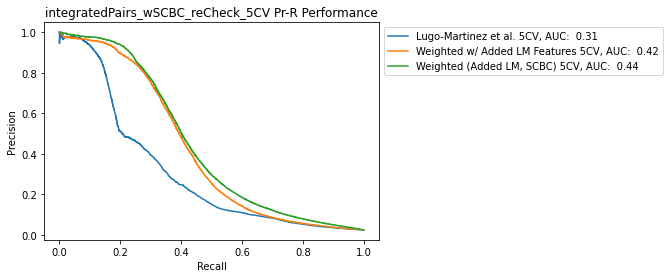

In [ ]:
#plot performance
precRecall_pairs = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, 'integratedPairs_wSCBC_reCheck_5CV', precRecall_pairs)

#Unit-Accuracy and Combined-Weight Cell-Line Specific Performance w/ original protein pair set expanded to include pairs for which colocalization and coexpression are available 

In [ ]:
performances4Comparision = [
                            [workDir + 'modelPerformance/modelsPerformance_cellSpecific_integratedPairs_Fantom+GTEx+Hein+HPA+Huttlin+Lugo-Martinez+Kaggle+NCI-60+SCBC+Wan/combined-weighted_results_h322m.csv', 'H322M -- Weighted w/ LM, SCBC, +FGK'],  
                            [workDir + 'modelPerformance/modelsPerformance_cellSpecific_integratedPairs_Fantom+GTEx+Hein+HPA+Huttlin+Lugo-Martinez+Kaggle+NCI-60+SCBC+Wan/combined-weighted_results_mcf7.csv', 'MCF7 -- Weighted w/ LM, SCBC, +FGK'],  
                            [workDir + 'modelPerformance/modelsPerformance_cellSpecific_integratedPairs_Fantom+GTEx+Hein+HPA+Huttlin+Lugo-Martinez+Kaggle+NCI-60+SCBC+Wan/combined-weighted_results_u251.csv', 'U251 -- Weighted w/ LM, SCBC, +FGK']  
                            ]

In [ ]:
scbc_cellLines = ['corr_U251', 'corr_A431', 'corr_MCF7', 'corr_H322', 'corr_HCC827']
for cellLine in scbc_cellLines:
    print('doing cellLine {0}...'.format(cellLine))
    cellLines_toRemove = list(set(scbc_cellLines) - set([cellLine]))
    cellLine_agnosticData = pd.read_csv(workDir + 'proteinComplexes/Drew_LM_Wilkins/SCBC-merged_integrated_MM+TSCS+Exp+Abun+Loc_test_ppiData.tsv', sep='\t')
    cellLine_agnosticData.drop(columns=cellLines_toRemove, axis=1, inplace=True)

    cellLine_agnosticData.loc[cellLine_agnosticData.loc[:, cellLine].isna(), cellLine] = \
      cellLine_agnosticData.loc[cellLine_agnosticData.loc[:, cellLine].isna(), 'NCI_prot_abun']
         
    cellLine_agnosticData.loc[:, 'NCI_prot_abun'] = cellLine_agnosticData.loc[:, cellLine]
    cellLine_agnosticData.drop(columns=cellLine, axis=1, inplace=True)   

    cellLine_agnosticData.to_csv(GWprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_test_ppiData--{0}_redo.tsv'.format(cellLine), index=False, sep='\t', header=True)

In [ ]:
scbc_cellLines = ['A431', 'H322', 'HCC827', 'MCF7', 'U251']
for cellLine in scbc_cellLines:
    print('cellLine: {0}'.format(cellLine))
    ppiPrediction_v2.run(workDir, 
                        LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model.tsv', 
                        LMprotein_complexesDir + 'integrated_training_labels_either_model.tsv',
                        GWprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_test_ppiData--corr_{0}_redo.tsv'.format(cellLine),
                        LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv',
                        expName='cellLine_{0}_wLMfeats_performance'.format(cellLine), hasHeadings=True)

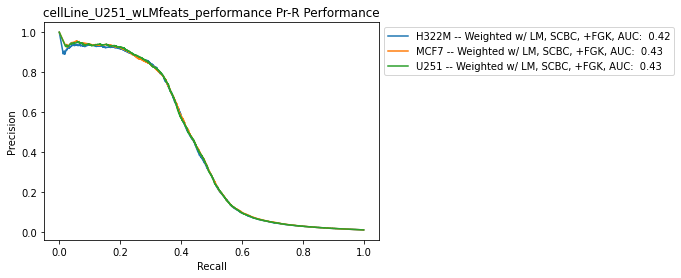

In [ ]:
#plot performance
precRecall_pairs = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, 'cellLine_U251_wLMfeats_performance', precRecall_pairs)

#Unit-Accuracy and Combined-Weight Cell-Line Specific 5-fold Cross Validation Performance w/ original protein pair set expanded to include pairs for which colocalization and coexpression are available 

In [ ]:
performances4Comparision = [
                            [workDir + 'modelPerformance/modelsPerformance_integrated_cell-specific_MM+TSCS+Exp+Abun+Loc+Kaggle+SCBC_5CV/combined-weighted_results_h322m.csv', 'H322M 5CV -- Weighted w/LM, SCBC, FGK+'],
                            [workDir + 'modelPerformance/modelsPerformance_integrated_cell-specific_MM+TSCS+Exp+Abun+Loc+Kaggle+SCBC_5CV/combined-weighted_results_mcf7.csv', 'MCF7 5CV -- Weighted w/LM, SCBC, FGK+'],
                            [workDir + 'modelPerformance/modelsPerformance_integrated_cell-specific_MM+TSCS+Exp+Abun+Loc+Kaggle+SCBC_5CV/combined-weighted_results_u251.csv', 'U-251 5CV -- Weighted w/LM, SCBC, FGK+'],
                            ]

In [ ]:
scbc_cellLines = ['corr_U251', 'corr_A431', 'corr_MCF7', 'corr_H322', 'corr_HCC827']
for cellLine in scbc_cellLines:
    print('doing cellLine {0}...'.format(cellLine))
    cellLines_toRemove = list(set(scbc_cellLines) - set([cellLine]))
    cellLine_agnosticData = pd.read_csv(workDir + 'proteinComplexes/Drew_LM_Wilkins/SCBC-merged_integrated_MM+TSCS+Exp+Abun+Loc_test_ppiData.tsv', sep='\t')
    cellLine_agnosticData.drop(columns=cellLines_toRemove, axis=1, inplace=True)

    cellLine_agnosticData.loc[cellLine_agnosticData.loc[:, cellLine].isna(), cellLine] = \
      cellLine_agnosticData.loc[cellLine_agnosticData.loc[:, cellLine].isna(), 'NCI_prot_abun']
         
    cellLine_agnosticData.loc[:, 'NCI_prot_abun'] = cellLine_agnosticData.loc[:, cellLine]
    cellLine_agnosticData.drop(columns=cellLine, axis=1, inplace=True)   

    cellLine_agnosticData.to_csv(GWprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_test_ppiData--{0}_redo.tsv'.format(cellLine), index=False, sep='\t', header=True)

In [ ]:
scbc_cellLines = ['A431', 'H322', 'HCC827', 'MCF7', 'U251']
for cellLine in scbc_cellLines:
    print('cellLine: {0}'.format(cellLine))
    ppiPrediction_v2.run(workDir, 
                        LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model.tsv', 
                        LMprotein_complexesDir + 'integrated_training_labels_either_model.tsv',
                        GWprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_test_ppiData--corr_{0}_redo.tsv'.format(cellLine),
                        LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv',
                        expName='cellLine_{0}_wLMfeats_performance'.format(cellLine), hasHeadings=True)

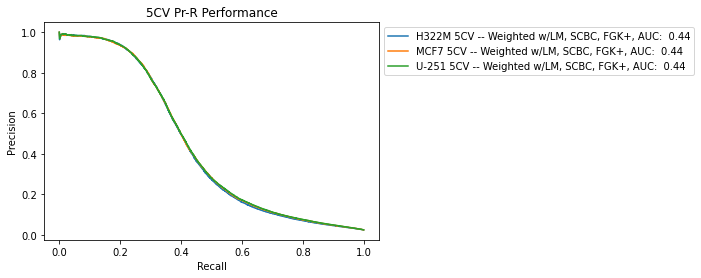

In [ ]:
#plot performance
precRecall_pairs = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, 'cellLine_U251_wLMfeats_performance', precRecall_pairs)